In [0]:
!pip install mxnet-cu100

#MXNet (From Scratch)

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

mx.random.seed(1)

data_ctx = mx.cpu()
model_ctx = mx.gpu()

In [0]:
def transform(data, label):
    return data.astype('float32')/255.0, label.astype('float32')

train_mnist = gluon.data.vision.MNIST(train = True, transform = transform)
test_mnist = gluon.data.vision.MNIST(train = False, transform = transform)

In [0]:
image, label = train_mnist[798]
print(image.shape, label.shape)

(28, 28, 1) ()


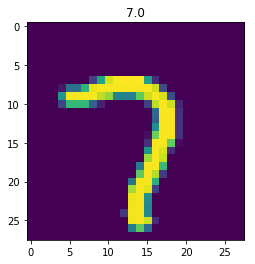

In [0]:
plt.imshow(image.reshape((28, 28)).asnumpy())
plt.title(label)
plt.show()


##Creating data loader for training and testing

In [0]:
batch_size = 64
training_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
testing_data = gluon.data.DataLoader(test_mnist, batch_size = batch_size, shuffle = False)

##Building the model

###Understanding dropout function

In [0]:
layer = nd.random.normal(0, 1, (1, 10))
a = nd.random.uniform(0, 1, layer.shape)
prob = 0.4
keep = 1 - prob
mask = a < keep
print(a)
print(mask)
print(layer)
print(layer * mask)


[[0.23734096 0.9831371  0.792735   0.04023623 0.34534866 0.18300699
  0.9539874  0.5292981  0.6002937  0.9280305 ]]
<NDArray 1x10 @cpu(0)>

[[1. 0. 0. 1. 1. 1. 0. 1. 0. 0.]]
<NDArray 1x10 @cpu(0)>

[[ 1.37109    -0.23789984  0.14867957 -0.49851316 -0.84815776  0.07811152
  -0.38241303 -0.05334064 -0.31002352 -1.7337203 ]]
<NDArray 1x10 @cpu(0)>

[[ 1.37109    -0.          0.         -0.49851316 -0.84815776  0.07811152
  -0.         -0.05334064 -0.         -0.        ]]
<NDArray 1x10 @cpu(0)>


In [0]:
weight_scale = .01

#  Allocate parameters for the first hidden layer
W1 = nd.random_normal(shape = (784, 256), scale=weight_scale, ctx=model_ctx)
b1 = nd.random_normal(shape = 256, scale=weight_scale, ctx=model_ctx)

#  Allocate parameters for the second hidden layer
W2 = nd.random_normal(shape = (256, 128), scale=weight_scale, ctx=model_ctx)
b2 = nd.random_normal(shape = 128, scale=weight_scale, ctx=model_ctx)

#  Allocate parameters for the output layer
W3 = nd.random_normal(shape=(128, 10), scale=weight_scale, ctx=model_ctx)
b3 = nd.random_normal(shape=10, scale=weight_scale, ctx=model_ctx)

params = [W1, b1, W2, b2, W3, b3]

for param in params:
    param.attach_grad()
    
def dropout(layer, drop_prob = 0.5):
    # drop_prob is what is the probability that a each neuron will get droped
    keep_prob = 1 - drop_prob
    mask = nd.random.uniform(0, 1, layer.shape).as_in_context(model_ctx) < keep_prob
    scale = 1/keep_prob if keep_prob > 0.0 else 0.0
    return layer * mask * scale

def neuralnetworks(inputs):
    layer1 = dropout(nd.relu(nd.dot(inputs, W1) + b1), 0.2)
    layer2 = dropout(nd.relu(nd.dot(layer1, W2) + b2), 0.2)
    return nd.softmax(nd.dot(layer2, W3) + b3)

##Defining our objective function

In [0]:
def categoricalcrossentropy(predictions, labels):
    return -nd.sum(labels * nd.log(predictions))

##Defining our parameters optimizer

In [0]:
def sgd(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

##Defining our accuracy function

In [0]:
def accuracy(predictions, labels):
    return nd.mean(predictions.argmax(1) == labels.argmax(1))

##Training the  model

In [0]:
epochs = 10
num_batches = 60000/batch_size
learning_rate = .001
losses = []
accs = []

for epoch in range(epochs):
    cumulative_loss = 0
    cumulative_acc = 0
    for features, labels in training_data:
        features = features.as_in_context(model_ctx).reshape((-1, 784))
        labels = labels.as_in_context(model_ctx).one_hot(10)
        with autograd.record():
            output = neuralnetworks(features)
            loss = categoricalcrossentropy(output, labels)
        loss.backward()
        sgd(params, learning_rate)
        cumulative_loss += loss
        cumulative_acc += accuracy(output, labels)
    print(f'Epoch: {epoch} Loss: {cumulative_loss.asscalar()/num_batches} Accuracy: {cumulative_acc.asscalar()/num_batches}')
    losses.append(cumulative_loss.asscalar()/num_batches)
    accs.append(cumulative_acc.asscalar()/num_batches)

Epoch: 0 Loss: 91.01678333333334 Accuracy: 0.5009833333333333
Epoch: 1 Loss: 24.889610416666667 Accuracy: 0.8861333333333333
Epoch: 2 Loss: 16.524120833333335 Accuracy: 0.9255833333333333
Epoch: 3 Loss: 12.392048958333334 Accuracy: 0.9443666666666667
Epoch: 4 Loss: 10.018997916666667 Accuracy: 0.9546333333333333
Epoch: 5 Loss: 8.511573958333333 Accuracy: 0.9617166666666667
Epoch: 6 Loss: 7.417365104166667 Accuracy: 0.9663
Epoch: 7 Loss: 6.6508859375 Accuracy: 0.9693333333333334
Epoch: 8 Loss: 5.983238020833333 Accuracy: 0.9727833333333333
Epoch: 9 Loss: 5.368407291666666 Accuracy: 0.9754


##Lets see test accuracy

In [0]:
acc = 0.0
batches = 0
for features, labels in testing_data:
    features = features.as_in_context(model_ctx).reshape((-1, 784))
    labels = labels.as_in_context(model_ctx).one_hot(10)
    predictions = neuralnetworks(features)
    acc += accuracy(predictions, labels)
    batches += 1
print(f'Test Accuracy: {acc.asscalar()/batches}')

Test Accuracy: 0.9686504777070064


In [0]:
def plot(losses = losses, accs = accs, model = neuralnetworks, samples = 5):
    plt.plot(losses, 'r')
    plt.title('Loss during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(accs, 'g')
    plt.title('Accuracy during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
    for i, batch in enumerate(test_mnist):
        features = batch[0].as_in_context(model_ctx).reshape((1, 784))
        labels = batch[1]
        predictions = model(features).argmax(1).asscalar()
        plt.imshow(features.reshape((28, 28)).asnumpy())
        plt.title(f'Predicted: {predictions}, Target: {labels}')
        plt.show()
        if i == samples:
            break

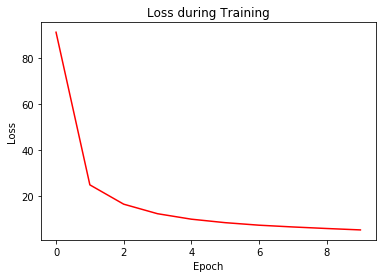

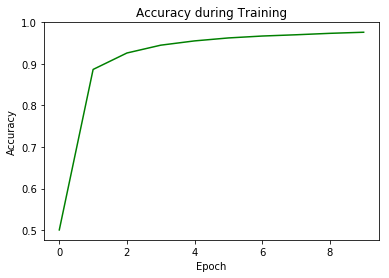

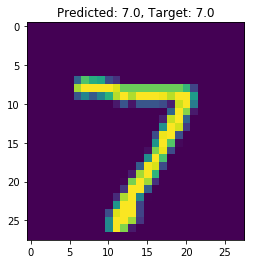

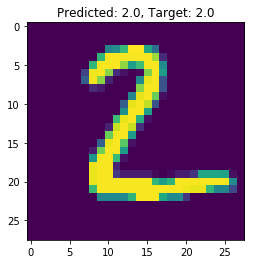

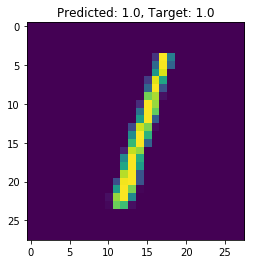

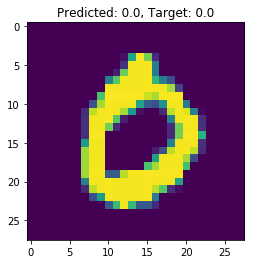

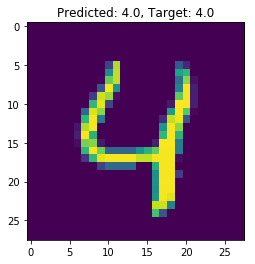

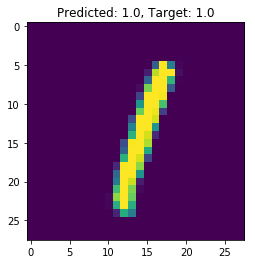

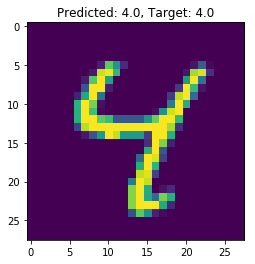

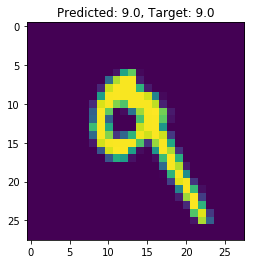

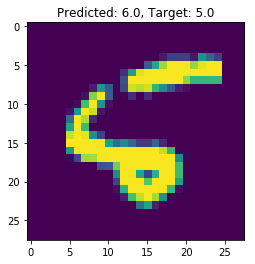

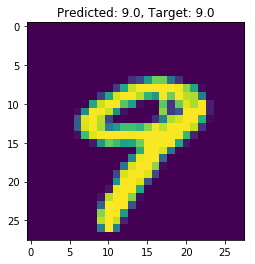

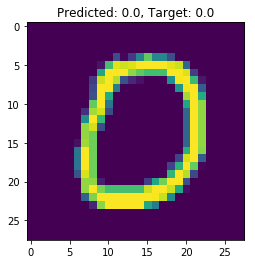

In [0]:
plot(samples = 10)